In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import PIL
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

%matplotlib inline

random_state = 22222

In [2]:
!ls data

happy-whale-and-dolphin


In [3]:
!ls data/happy-whale-and-dolphin/

sample_submission.csv  test_images  train.csv  train_images


In [4]:
full_train_df = pd.read_csv('data/happy-whale-and-dolphin/train.csv')

full_train_df

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1
51029,fff8b32daff17e.jpg,cuviers_beaked_whale,1184686361b3
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e


In [5]:
full_train_df['species'].value_counts()

bottlenose_dolphin           9664
beluga                       7443
humpback_whale               7392
blue_whale                   4830
false_killer_whale           3326
dusky_dolphin                3139
spinner_dolphin              1700
melon_headed_whale           1689
minke_whale                  1608
killer_whale                 1493
fin_whale                    1324
gray_whale                   1123
bottlenose_dolpin            1117
kiler_whale                   962
southern_right_whale          866
spotted_dolphin               490
sei_whale                     428
short_finned_pilot_whale      367
common_dolphin                347
cuviers_beaked_whale          341
pilot_whale                   262
long_finned_pilot_whale       238
white_sided_dolphin           229
brydes_whale                  154
pantropic_spotted_dolphin     145
globis                        116
commersons_dolphin             90
pygmy_killer_whale             76
rough_toothed_dolphin          60
frasiers_dolph

Some of the species names are incorrect (e.g. "kiler_whale") or have duplicate entries (e.g. "globis" and "pilot_whale" for "short_finned_pilot_whale"), so we'll fix that here.

In [6]:
full_train_df['species'].replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

full_train_df['species'].value_counts()

bottlenose_dolphin           10781
beluga                        7443
humpback_whale                7392
blue_whale                    4830
false_killer_whale            3326
dusky_dolphin                 3139
killer_whale                  2455
spinner_dolphin               1700
melon_headed_whale            1689
minke_whale                   1608
fin_whale                     1324
gray_whale                    1123
southern_right_whale           866
short_finned_pilot_whale       745
spotted_dolphin                490
sei_whale                      428
common_dolphin                 347
cuviers_beaked_whale           341
long_finned_pilot_whale        238
white_sided_dolphin            229
brydes_whale                   154
pantropic_spotted_dolphin      145
commersons_dolphin              90
pygmy_killer_whale              76
rough_toothed_dolphin           60
frasiers_dolphin                14
Name: species, dtype: int64

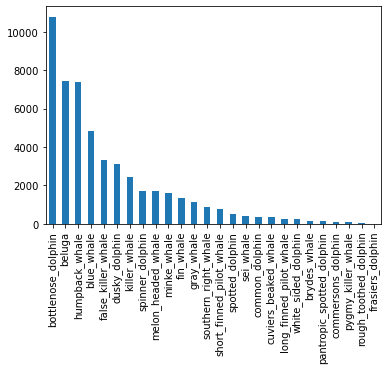

In [44]:
full_train_df['species'].value_counts().plot.bar();

# PUT SOME IMAGES AND STUFF HERE***

# Creating train/val/test splits

First, we'll make a new folder structure to house our own local train/val/test split.

In [7]:
kaggle_data_dir = 'data/happy-whale-and-dolphin/train_images'
local_split_dir = 'data/local_split'

In [34]:
local_dataset_imgs_names = [file for file in os.listdir(kaggle_data_dir)]
local_dataset_imgs_names[0:10]

['00021adfb725ed.jpg',
 '000562241d384d.jpg',
 '0007c33415ce37.jpg',
 '0007d9bca26a99.jpg',
 '00087baf5cef7a.jpg',
 '000a8f2d5c316a.jpg',
 '000be9acf46619.jpg',
 '000bef247c7a42.jpg',
 '000c3d63069748.jpg',
 '000c476c11bad5.jpg']

In [35]:
print('There are', len(local_dataset_imgs_names), 'whale and dolphin images to be split.')

There are 51033 whale and dolphin images to be split.


In [27]:
train_folder = os.path.join(local_split_dir, 'train')
val_folder = os.path.join(local_split_dir, 'validation')
test_folder = os.path.join(local_split_dir, 'test')

In [146]:
train_folder_sp = os.path.join(local_split_dir, 'sp/train')
val_folder_sp = os.path.join(local_split_dir, 'sp/validation')
test_folder_sp = os.path.join(local_split_dir, 'sp/test')

train_folder_id = os.path.join(local_split_dir, 'id/train')
val_folder_id = os.path.join(local_split_dir, 'id/validation')
test_folder_id = os.path.join(local_split_dir, 'id/test')

Only run the below cell during initial setup.

In [10]:
# os.mkdir(local_split_dir)

# os.mkdir(train_folder_sp)
# os.mkdir(val_folder_sp)
# os.mkdir(test_folder_sp)

# os.mkdir(train_folder_id)
# os.mkdir(val_folder_id)
# os.mkdir(test_folder_id)

### The train/val/test split on the dataframe

In [21]:
train_val_df, test_df = train_test_split(full_train_df, test_size=.05, random_state=random_state)

In [23]:
train_df, val_df = train_test_split(train_val_df, test_size=.05, random_state=random_state)

In [30]:
train_imgs_names = list(train_df['image'].values)
val_imgs_names = list(val_df['image'].values)
test_imgs_names = list(test_df['image'].values)

Now we'll copy the images from kaggle's train folder into our new folder structure, according to the train/val/test split we just performed on the dataframe.

Only run this cell during initial setup.

In [36]:
# # copy train images
# for image in train_imgs_names:
#     origin = os.path.join(kaggle_data_dir, image)
#     destination = os.path.join(train_folder, image)
#     shutil.copyfile(origin, destination)
    
# # copy val images
# for image in val_imgs_names:
#     origin = os.path.join(kaggle_data_dir, image)
#     destination = os.path.join(val_folder, image)
#     shutil.copyfile(origin, destination)
    
# # copy test images
# for image in test_imgs_names:
#     origin = os.path.join(kaggle_data_dir, image)
#     destination = os.path.join(test_folder, image)
#     shutil.copyfile(origin, destination)

Lastly, because of the version of TensorFlow we're using (2.5), the image_dataset_from_directory function expects the images to not be in subdirectories, so we'll make an 'images' folder inside each of our train, val, and test folders and move each image into those subfolders. If using a later version of TF, dont' run the next two cells (you'll also need to have adjusted the module address in the first import cell).

In [126]:
# train_folder_images = os.path.join(train_folder, 'images')
# val_folder_images = os.path.join(val_folder, 'images')
# test_folder_images = os.path.join(test_folder, 'images')

# os.mkdir(train_folder_images)
# os.mkdir(val_folder_images)
# os.mkdir(test_folder_images)

In [133]:
# # move train images
# train_imgs_names = [file for file in os.listdir(train_folder) if file.endswith('jpg')]
# for image in train_imgs_names:
#     origin = os.path.join(train_folder, image)
#     destination = os.path.join(train_folder_images, image)
#     shutil.move(origin, destination)
    
# # move val images
# val_imgs_names = [file for file in os.listdir(val_folder) if file.endswith('jpg')]
# for image in val_imgs_names:
#     origin = os.path.join(val_folder, image)
#     destination = os.path.join(val_folder_images, image)
#     shutil.move(origin, destination)
    
# # move test images
# test_imgs_names = [file for file in os.listdir(test_folder) if file.endswith('jpg')]
# for image in test_imgs_names:
#     origin = os.path.join(test_folder, image)
#     destination = os.path.join(test_folder_images, image)
#     shutil.move(origin, destination)

In [137]:
print('There are', len(os.listdir(train_folder)), 'images in the training set.')
print('There are', len(os.listdir(val_folder)), 'images in the validation set.')
print('There are', len(os.listdir(test_folder)), 'images in the test set.')

There are 46056 images in the training set.
There are 2425 images in the validation set.
There are 2552 images in the test set.


### Duplicating the dataset and creating folders for each subclass

In [147]:
os.mkdir('data/local_split/sp')
os.mkdir('data/local_split/id')

In [ ]:
for folder in os.listdir('data/local_split'):

In [139]:
for folder in os.listdir('data/local_split'):
    for i in range(0, len(folder)):
        

train
validation
test


In [145]:
for i in range(0, len(os.listdir('data/local_split/train'))):

1. Make local_split folder
2. Make id and sp folders inside local_split
3. Make train, val, and test folders inside id AND sp
4. Make class subfolders inside all six folders (train, val, test inside both of id AND sp)
5. Copy files from Kaggle folder to train, val, and test folders sp AND to train, val, and test folders id

# Creating subfolders for each class

In [183]:
# Make subfolders for each class

for class_name in full_train_df['species'].unique():
    os.mkdir(os.path.join('data/local_split/sp', class_name))
    
for class_name in full_train_df['individual_id'].unique():
    os.mkdir(os.path.join('data/local_split/id', class_name))

In [184]:
# Move each image to the appropriate subfolder

In [176]:
full_train_df[full_train_df['image'] == image]['species'].values[0]
full_train_df[full_train_df['image'] == image]['individual_id'].values[0]

'4b00fe572063'

# BELOW ASSUMES ID AND SP FOLDERS WITH TRAIN, VALIDATION, AND TEST FOLDERS WITHIN

In [195]:
# Move all images in 'sp' to correct species subfolders
for folder in os.listdir('data/local_split/sp'):
    if folder in ['train', 'test', 'validation']:
        files = [file for file in os.listdir(os.path.join('data/local_split/sp', folder)) if file.endswith('jpg')]
        for image in files:
            species = full_train_df[full_train_df['image'] == image]['species'].values[0]
            origin = os.path.join('data/local_split/sp', folder, image)
            destination = os.path.join('data/local_split/sp', species)
            shutil.move(origin, destination)

# Move all images in 'id' to correct individual_id subfolders
for folder in os.listdir('data/local_split/id'):
    if folder in ['train', 'test', 'validation']:
        files = [file for file in os.listdir(os.path.join('data/local_split/id', folder)) if file.endswith('jpg')]
        for image in files:
            individual_id = full_train_df[full_train_df['image'] == image]['individual_id'].values[0]
            origin = os.path.join('data/local_split/id', folder, image)
            destination = os.path.join('data/local_split/id', individual_id)
            shutil.move(origin, destination)            

In [194]:
full_train_df[full_train_df['image'] == '0007c33415ce37.jpg']['species'].values[0]

'false_killer_whale'

In [ ]:
full_train_df


In [147]:
os.mkdir('data/local_split/sp')
os.mkdir('data/local_split/id')

In [199]:
# Make subfolders for each class

for class_name in full_train_df['species'].unique():
    for folder in ['train', 'validation', 'test']:
        os.mkdir(os.path.join('data/local_split/sp', folder, class_name))
    
for class_name in full_train_df['individual_id'].unique():
    for folder in ['train', 'validation', 'test']:
        os.mkdir(os.path.join('data/local_split/id', folder, class_name))

In [36]:
# # copy train images
# for image in train_imgs_names:
#     origin = os.path.join(kaggle_data_dir, image)
#     destination = os.path.join(train_folder, image)
#     shutil.copyfile(origin, destination)
    
# # copy val images
# for image in val_imgs_names:
#     origin = os.path.join(kaggle_data_dir, image)
#     destination = os.path.join(val_folder, image)
#     shutil.copyfile(origin, destination)
    
# # copy test images
# for image in test_imgs_names:
#     origin = os.path.join(kaggle_data_dir, image)
#     destination = os.path.join(test_folder, image)
#     shutil.copyfile(origin, destination)

In [195]:
# Move all images in 'sp' to correct species subfolders
for folder in os.listdir('data/local_split/sp'):
    if folder in ['train', 'test', 'validation']:
        files = [file for file in os.listdir(os.path.join('data/local_split/sp', folder)) if file.endswith('jpg')]
        for image in files:
            species = full_train_df[full_train_df['image'] == image]['species'].values[0]
            origin = os.path.join('data/local_split/sp', folder, image)
            destination = os.path.join('data/local_split/sp', species)
            shutil.move(origin, destination)

# Move all images in 'id' to correct individual_id subfolders
for folder in os.listdir('data/local_split/id'):
    if folder in ['train', 'test', 'validation']:
        files = [file for file in os.listdir(os.path.join('data/local_split/id', folder)) if file.endswith('jpg')]
        for image in files:
            individual_id = full_train_df[full_train_df['image'] == image]['individual_id'].values[0]
            origin = os.path.join('data/local_split/id', folder, image)
            destination = os.path.join('data/local_split/id', individual_id)
            shutil.move(origin, destination)            

### Creating the dataset in TensorFlow

We'll have two sets of labels, one for species and one for individual ids. This way, we can start by building models that only predict the species. If these models are successful, we'll move on to predicting the individuals.

In [110]:
train_labels_sp = list(train_df['species'])
train_labels_id = list(train_df['individual_id'])
val_labels_sp = list(val_df['species'])
val_labels_id = list(val_df['individual_id'])
test_labels_sp = list(test_df['species'])
test_labels_id = list(test_df['individual_id'])

Next, we'll verify that the dataframes are in alphanumeric order (so that the labels match up with the correct images).

In [105]:
list(os.walk(train_folder))[0][2] == list(train_df['image'])

True

In [106]:
list(os.walk(val_folder))[0][2] == list(val_df['image'])

True

In [107]:
list(os.walk(test_folder))[0][2] == list(test_df['image'])

True

In [138]:
tf.keras.preprocessing.image_dataset_from_directory(
    train_folder, 
    labels=train_labels_sp, 
    label_mode='categorical',
    color_mode='rgb', 
    batch_size=32, 
    image_size=(256, 256), 
    shuffle=True, 
    seed=random_state
)

ValueError: Expected the lengths of `labels` to match the number of files in the target directory. len(labels) is 46056 while we found 0 files in data/local_split/train.